# pretrain LLM

## 评估生成的文本

### 生成文本

In [1]:
import torch
from previous_ch import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}



In [2]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [3]:
import tiktoken
from previous_ch import generate_text_simple

def text_to_token_ids(text, tokenizer):
    # 为了添加batch维度
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

In [4]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

In [5]:
encoded_tensor = text_to_token_ids(start_context, tokenizer)
encoded_tensor


tensor([[6109, 3626, 6100,  345]])

In [6]:
def token_ids_to_text(token_ids, tokenizer):
    flat= tokenizer.decode(token_ids.squeeze(0).tolist())
    return flat

In [7]:
token_ids_to_text(text_to_token_ids(start_context, tokenizer), tokenizer)

'Every effort moves you'

In [8]:
token_ids = generate_text_simple(model = model, idx = encoded_tensor, max_new_tokens=10, context_size=GPT_CONFIG_124M["context_length"])
token_ids_to_text(token_ids, tokenizer)

'Every effort moves you rentingetic wasnم refres RexMeCHicular stren'

### 评估生成文本，交叉熵，困惑度

In [9]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]])

In [10]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape)

torch.Size([2, 3, 50257])


In [11]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [12]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [13]:
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

In [14]:
probas

tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0537e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1207e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]])

In [15]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])


In [16]:
log = torch.log(target_probas_1)
log

tensor([ -9.5042, -10.3796, -11.3677])

In [17]:
###交叉熵，尽可能为0,交叉熵也是负对数概率


-1 *torch.mean(log)



tensor(10.4172)

交叉熵的另一种实现，有些问题，形状是如何对应的，是怎么计算的

In [18]:
logits.shape

torch.Size([2, 3, 50257])

In [19]:
logits_flat = logits.flatten(0, 1)
logits_flat.shape

torch.Size([6, 50257])

In [20]:
targets_flat = targets.flatten()
targets_flat.shape


torch.Size([6])

In [21]:
torch.nn.functional.cross_entropy(logits_flat, targets_flat)

tensor(10.7940)

### 计算训练和验证的loss

In [22]:
import os
import requests

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


In [23]:
text_data[:100]


'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g'

In [24]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [25]:
from previous_ch import create_dataloader_v1

train_ration = 0.90
split_idx = int(train_ration * len(text_data))
print(split_idx)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

18431


In [26]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [27]:
print("train_data")

for x, y in train_loader:
    print(x.shape, y.shape)


# getitem中的迭代，一个是train data 一个是target


train_data
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [28]:
for x, y in val_loader:
    print(x.shape, y.shape)

torch.Size([2, 256]) torch.Size([2, 256])


In [29]:
##完整性检查，用numel计算token的总数


train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [30]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

这里的loss的计算问题和刚才上面的一样，加了batch以后具体怎么运作的看一下？？？

In [31]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
device

device(type='cpu')

In [34]:
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


In [35]:
# perplexity 放大模型的误差？？，数字为有多少个词不确定，这是为什么查一下

torch.exp(torch.tensor(train_loss))

tensor(59135.2891)

### 训练LLM！！！

计算图是什么？？？

In [36]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train() # 防止忘记，有备无患，不是必须
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [37]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.01)


正常大模型只训练1-1.5epoch

In [38]:
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.110, Val loss 8.338
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.660, Val loss 7.047
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.736, Val loss 6.607
Ep 3 (Step 000025): Train loss 5.192, Val loss 6.341
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.408, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.060, Val loss 6.225
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.722, Val loss 6.162
Every effort moves you know it was not that the picture--I had the fact with the la

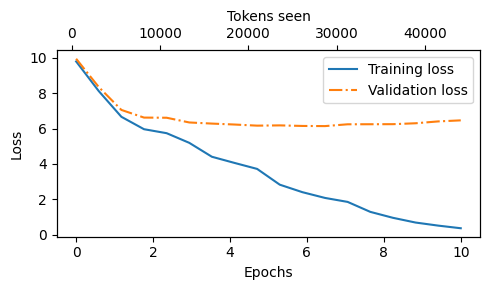

In [39]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### 控制LLM随机性的采样策略（使LLM更有随机性）

### 温度控制

In [40]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=-1)
probas

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [41]:
next_token_id = torch.argmax(probas, dim=-1, keepdim=True)
print(inverse_vocab[next_token_id.item()])


forward


使用torch.multinomial进行采样，根据概率采样，如果禁用随机种子返回的结果有可能不同

In [42]:
# torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


输出10000次查看频率

In [43]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(10000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

664 x closer
11 x every
0 x effort
5718 x forward
32 x inches
0 x moves
1 x pizza
3536 x toward
38 x you


对softmax函数引入温度

In [44]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

In [45]:
temperatures = [1, 0.5, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

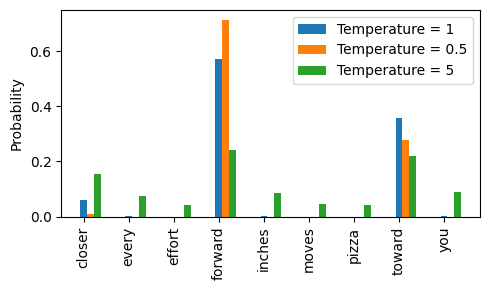

In [46]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()


top-k采样，只使用最大的k个logits（其他设为负无穷）来进行softmax。这样可以保证LLM产生概率小的数的同时增加随机性

In [47]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [48]:
top_k = 3
toplogits, topindices = torch.topk(next_token_logits, k=top_k)#输出为排序好的
print(toplogits)
print(topindices) 

tensor([6.7500, 6.2800, 4.5100])
tensor([3, 7, 0])


In [49]:
new_logits = torch.where(
    condition = next_token_logits < toplogits[-1],
    input = torch.tensor(float("-inf")),
    other = next_token_logits
)
print(new_logits)



tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [50]:
torch.softmax(new_logits, dim=-1)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

### 将采样策略运用到生成文本函数

In [51]:
tokenizer

<Encoding 'gpt2'>

In [52]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]


        if top_k is not None:
            toplogits, topindices = torch.topk(logits, top_k)
            logits = torch.where(
                condition = logits < toplogits[: , -1],
                input = torch.tensor(float("-inf")),
                other = logits
            )

        if temperature > 0:
            logits = torch.softmax(logits / temperature, dim=-1)  
            idx_next = torch.multinomial(logits, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:  
            break
        # Get the idx of the vocab entry with the highest logits value
        idx = torch.cat((idx, idx_next), dim=1) 

    return idx

In [53]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youlit terrace.



" he said deprecating laugh


### 加载和保存自己训练的模型

In [54]:
torch.save(model.state_dict(), "model.pth")


In [55]:
from previous_ch import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

model = GPTModel(GPT_CONFIG_124M)

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load("model.pth", map_location=device))
# torch.load("model.pth", map_location=device)

<All keys matched successfully>

In [57]:
import torch
from previous_ch import GPTModel

In [58]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [59]:
import os
import urllib.request
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(NEW_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("hello", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 hello, FL—Maggaz, one of seven "navy SEAL" teams deployed during the 2003 invasion of Afghanistan has pleaded


In [60]:
# torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("hello", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 hello [4:18:01 AM] Peter Coffin: that fucking shit goes down at the club


Yeah there is probably
